In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.odr import ODR, Model, Data, RealData
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)

plt.rc("font", family=["Helvetica", "Arial"]) # skifter skrifttype
plt.rc("axes", labelsize=22)   # skriftstørrelse af `xlabel` og `ylabel`
plt.rc("xtick", labelsize=22, top=True, direction="out")
plt.rc("ytick", labelsize=22, right=True, direction="out")
plt.rc("axes", titlesize=22)
plt.rc("legend", fontsize=20)

In [2]:
def getNormalized(filepath):
    data = np.loadtxt(filepath, skiprows=1)
    return (data[2:, 0], (data[2:,1]-data[0,0])/data[1, 1])
def getAngles(filepath, isTrans, direction="a-g"):
    data = np.loadtxt(filepath, skiprows=1)
    t1s = data[2:, 0]
    t2s = data[2:, 2]-t1s ## Assume reflection
    if isTrans:
        t2s = td_to_t2_trans(t1s, data[2:,2], direction)

    return (t1s, t2s)

# def combineRandT(file1, file2):
#     data1 = np.loadtxt(file1, skiprows=8)
#     data2 = np.loadtxt(file2, skiprows=8)
#     return (data1[1:, 0], data1[1:,1]/data1[0, 1] + data2[1:,1]/data2[0, 1]) #Assuming measured @ the same theta_1
def Rp(t1, t2):
    return np.tan(t1-t2)**2/np.tan(t1+t2)**2
def Tp(t1, t2):
    return 1-Rp(t1, t2)
def Rs(t1, t2):
    return np.sin(t1-t2)**2/(np.sin(t1+t2))**2
def Ts(t1, t2):
    return 1-Rs(t1, t2)
def getTheo(t1, t2, pol):
    if pol is "s":
        return (Ts(t1, t2), Rs(t1, t2))
    elif pol is "p":
        return (Tp(t1, t2), Rp(t1, t2))

def td_to_t2_trans(t1, td, direction): #Prime or not depends on whether the detector angles starts from 180 or not
    td_corr = 180-td
    t2 = t1-td_corr ## Assume "a-g" direction - just to initialize
    if direction == "g-a":
        t2 = t1+td_corr
    return t2

<ErrorbarContainer object of 3 artists>

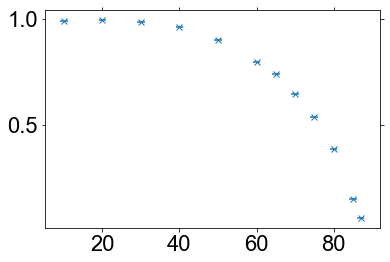

In [3]:
plt.errorbar(*getNormalized("finalized_data/a-g s trans.txt"), xerr=1, fmt='x')

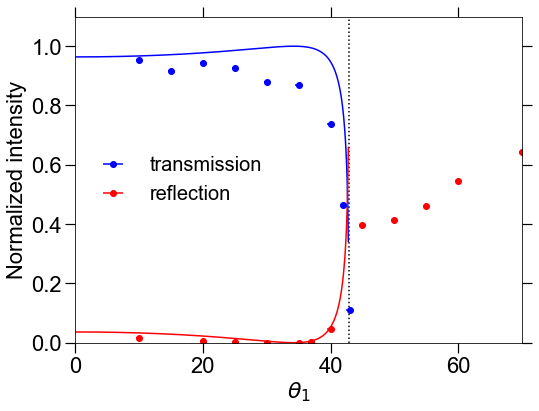

In [98]:
direction = "g-a"
polarization = "p"
n_air = 1
n_glass = 1.47 # to be found

t_c = np.arcsin(1/n_glass)*180/np.pi
t_b = np.arctan(n_glass)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

if direction == "a-g":
    n_1 = n_air
    n_2 = n_glass
    ax.set_xlim(0, 90)
else:
    n_1 = n_glass
    n_2 = n_air
    ax.set_xlim(0, 70)
    ax.vlines(t_c, 0, 1.1, ls=':')

theta_1s = np.linspace(0, np.pi/2, 1000)
theta_2s = np.arcsin(n_1*np.sin(theta_1s)/n_2)
theo_T, theo_R = getTheo(theta_1s, theta_2s, polarization)

ax.plot(theta_1s*180/np.pi, theo_T, 'b')
ax.plot(theta_1s*180/np.pi, theo_R, 'r')

trans = getNormalized("finalized_data/"+ direction +" "+ polarization + " trans.txt")
refl = getNormalized("finalized_data/"+ direction +" "+ polarization + " refl.txt")

# NB: theo_T[1] scaling to accomodate for the fact that I(0) is NOT the max - and a weird parameter to normalize with
ax.errorbar(trans[0], trans[1]*theo_T[1], xerr=0.5, fmt='bo', label="transmission") 
# Perhaps do similar scaling for reflected light
ax.errorbar(refl[0], refl[1], xerr=0.5, fmt='ro', label="reflection")
# plt.title("g-a s")


ax.set_ylim(0, 1.1)
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("Normalized intensity")
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)

# plt.savefig("prelim_figs/"+direction +" "+ polarization + ".png", dpi=200)

In [5]:
#TODO: estimate error in theta_D and theta_1 -> propagate to sine v. sine plot 
#TODO: Collect all reflected angles and make fit
#TODO: Collect all refracted angles and make fit 

td_err = 1 #degree
t_1_err = 0.5 #degree

Beta:  [0.99851252 2.81576341]
Beta errors:  [0.00743814 0.39105396]


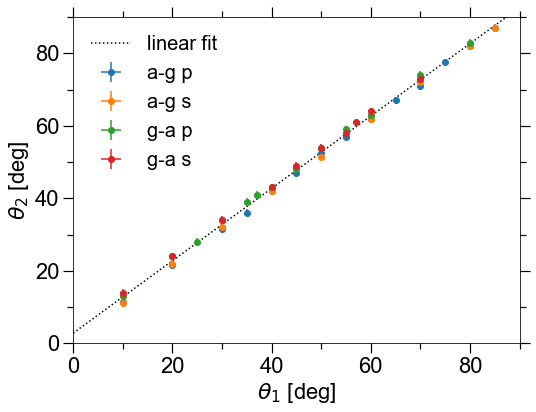

In [99]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)

def linear_fit(B, x):
    return B[0]*x+B[1]

types = [
    'a-g p',
    'a-g s',
    'g-a p',
    'g-a s'
]

total_t1s = np.array([])
total_t2s = np.array([])

for t in types:
    t1s, t2s = getAngles("finalized_data/"+t+" refl.txt", False)
    total_t1s=np.concatenate((total_t1s, t1s))
    total_t2s=np.concatenate((total_t2s, t2s))
    ax.errorbar(t1s, t2s, yerr=1, xerr=0.5, fmt='o', label=t)

linear = Model(linear_fit)
data = RealData(total_t1s, total_t2s, sx=np.ones(np.shape(total_t1s))*0.5, sy=np.ones(np.shape(total_t1s)))
odr = ODR(data, linear, beta0=[1., 0.])
output=odr.run()

xs = np.linspace(0, 90, 100)
ax.plot(xs, linear_fit(output.beta, xs), 'k:', label="linear fit")
ax.set_xlabel("$\\theta_1$ [deg]")
ax.set_ylabel("$\\theta_2$ [deg]")
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.set_xlim(0, 90)
ax.set_ylim(0, 90)
ax.yaxis.set_minor_locator(MultipleLocator(10))
ax.xaxis.set_minor_locator(MultipleLocator(10))
print('Beta: ', output.beta)
print('Beta errors: ', output.cov_beta.diagonal()**0.5)
# plt.savefig("reflection_linear_fit_v1.pdf")

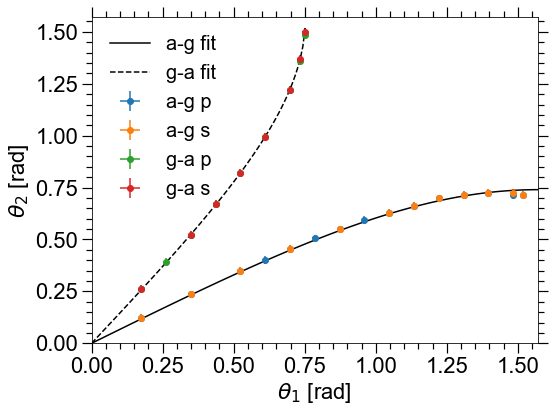

In [100]:
#Calculate t2 and fit for n2
#Syntax for getAngles(filepath, isTransmission, direction)
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(8, 6)
def double_sine_func_g_a(B, x):
    return np.arcsin(B[0]*np.sin(x))
def double_sine_func_a_g(B, x):
    return np.arcsin(1./B[0]*np.sin(x))

t1_err_rad = t_1_err/180*np.pi
t2_err_rad = td_err/180*np.pi


total_t1s_a_g = np.array([])
total_t2s_a_g = np.array([])

total_t1s_g_a = np.array([])
total_t2s_g_a = np.array([])

for t in types[:2]: #a-g data
    t1s, t2s = getAngles("finalized_data/"+t+" trans.txt", True, t[:3]) 
    total_t1s_a_g = np.concatenate((total_t1s_a_g, t1s/180*np.pi))
    total_t2s_a_g = np.concatenate((total_t2s_a_g, t2s/180*np.pi))
    ax.errorbar(t1s/180*np.pi, t2s/180*np.pi, fmt='o', label=t, yerr=t2_err_rad, xerr=t1_err_rad)

for t in types[2:]: #g-a data
    t1s, t2s = getAngles("finalized_data/"+t+" trans.txt", True, t[:3])
    total_t1s_g_a = np.concatenate((total_t1s_g_a, t1s/180*np.pi))
    total_t2s_g_a = np.concatenate((total_t2s_g_a, t2s/180*np.pi))
    ax.errorbar(t1s/180*np.pi, t2s/180*np.pi, fmt='o', label=t, yerr=t2_err_rad, xerr=t1_err_rad)

# def sine_err_prop(theta, err):
#     return np.abs(np.cos(theta)))*err

# t1_errs_rad = sine_err_prop()


double_sine_a_g = Model(double_sine_func_a_g)
double_sine_g_a = Model(double_sine_func_g_a)

data_a_g = RealData(total_t1s_a_g, total_t2s_a_g, sx=np.ones(np.shape(total_t1s_a_g))*t1_err_rad, sy=np.ones(np.shape(total_t1s_a_g))*t2_err_rad)
data_g_a = RealData(total_t1s_g_a, total_t2s_g_a, sx=np.ones(np.shape(total_t1s_g_a))*t1_err_rad, sy=np.ones(np.shape(total_t1s_g_a))*t2_err_rad)

odr_a_g = ODR(data_a_g, double_sine_a_g, beta0=[1.5])
odr_g_a = ODR(data_g_a, double_sine_g_a, beta0=[1])
output_a_g=odr_a_g.run()
output_g_a=odr_g_a.run()

xs1 = np.linspace(0, 1.6, 100)
xs2 = np.linspace(0, 0.8, 100)
plt.plot(xs1, double_sine_func_a_g(output_a_g.beta, xs1), 'k', label="a-g fit")

plt.plot(xs2, double_sine_func_g_a(output_g_a.beta, xs2), 'k--' ,label="g-a fit")

ax.set_xlabel("$\\theta_1$ [rad]")
ax.set_ylabel("$\\theta_2$ [rad]")
ax.set_xlim(0, np.pi/2)
ax.set_ylim(0, np.pi/2)
ax.legend(frameon=False)
plt.tick_params(which='major', axis='both', length=10, width=1.2)
plt.tick_params(which='minor', axis='both', length=6, width=1.2)
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_minor_locator(MultipleLocator(0.05))
ax.xaxis.set_major_locator(MultipleLocator(0.25))
# plt.savefig("transmission_fit_ref_index_v1.pdf")

In [74]:
output_g_a.pprint()
output_a_g.pprint()

Beta: [1.46283163]
Beta Std Error: [0.00076614]
Beta Covariance: [[3.06040329e-05]]
Residual Variance: 0.01917934212980632
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence
Beta: [1.48313609]
Beta Std Error: [0.00421357]
Beta Covariance: [[5.53220423e-05]]
Residual Variance: 0.32092375989756106
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [77]:
np.sqrt(3.06040329e-05)

0.005532091186884034

In [90]:
count_a_g, count_g_a

(27, 17)